## U shape PHP dynamics with multiple liquid slugs - with heat transfer

## $\frac{\partial \theta }{\partial \mathcal{T}} = \nabla^2 \theta$

In [1]:
@time using Plots
pyplot()

 17.795655 seconds (19.47 M allocations: 1.001 GiB, 2.67% gc time)


Plots.PyPlotBackend()

In [2]:
@time using DifferentialEquations

 46.599948 seconds (61.50 M allocations: 3.411 GiB, 2.45% gc time)


In [3]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing

include("Boiling.jl")
using ..Boiling

cd(dirname(pwd()))
cd("src") 

In [39]:
function getoneXarrayindex(X,Xarray)
    for i = 1:length(Xarray)
        if (X >= Xarray[i] && X <= Xarray[i+1])
            return i
        end
    end
    
    return length(Xarray)
end

getoneXarrayindex (generic function with 1 method)

In [74]:
function getsuperheat(Xstation,sys)

    wallindex = getoneXarrayindex(Xstation,sys.wall.Xarray)
    liquidindex = sys.mapping.walltoliquid[wallindex]

    Δθ = sys.wall.θarray[wallindex] - sys.liquid.θarrays[liquidindex[1]][liquidindex[2]]

    return Δθ
end

getsuperheat (generic function with 1 method)

## Parameters of the PHP

In [4]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];

    θinitial=1.0
    θ  = 0.15;
    θe = 1 + θ;
    θc = 1 - θ;

    
    He  = 3000.0; # H for wall and vapor
    Hc  = 3000.0; # depreciated
    Hwc = 3000.0; # H for wall and condenser liquid
    Hₗ   =  3000.0; # liquid wall heat transfer coeffcient

    
    X0 = 0.5;

    γ = 1.4;

In [5]:
    
    d = 1/30 # dimensionless diameter
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    angle = pi/2 # inclination angle 
    closedornot = false

false

In [6]:
    nucleatenum = 2
    Xstations = sort(rand(nucleatenum).*L)
    Δt = 0.05

0.05

## Pipe definition

In [7]:
tube = Tube(d,L,L2D,angle,closedornot)

Tube(0.03333333333333333, 4.0, 2.0, 1.5707963267948966, false)

## Evaporator and condenser definition

In [8]:
Xe = map(tuple, [0.0], [2.0])
# Xe = map(tuple, [0.0,3.0], [1.0,4.0])
We = [200.0]
evap = Evaporator(He,θe,Xe,We)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 2.0)], [200.0])

In [9]:
Xc = map(tuple, [2.0], [4.0])
# Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc,Hwc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(2.0, 4.0)], 3000.0)

## Vapor plug and liquid slug initialization

In [10]:
N=500
X0 = [(0.5,2.5)]
dXdt0 = [(0.0,0.0)]
ρₗ = 1000
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(γ,Hₗ,ρₗ,ω0,℘,X0,dXdt0,Xarrays,θarrays)

Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(0.5, 2.5)], Tuple{Float64,Float64}[(0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5]], Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

In [11]:
P = [1.0,1.0];
δ = 0.05*P;
vapors=Vapor(γ,P,δ)

Vapor(1.4, [1.0, 1.0], [0.05, 0.05])

In [12]:
α = 1 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray)

Wall(1.0, 0.05, [1.3145014719881525, 3.633825858889219], [0.0, 0.008016032064128256, 0.01603206412825651, 0.02404809619238477, 0.03206412825651302, 0.04008016032064128, 0.04809619238476954, 0.056112224448897796, 0.06412825651302605, 0.07214428857715431  …  3.9278557114228456, 3.935871743486974, 3.943887775551102, 3.9519038076152304, 3.9599198396793587, 3.967935871743487, 3.975951903807615, 3.9839679358717435, 3.9919839679358717, 4.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [13]:
# struct Mapping
#     walltoliquid::Array{Tuple{Int64,Int64},1}
#     liquidtowall::Array{Array{Int64,1},1}
# end

In [14]:
walltoliquid, liquidtowall = constructmapping(Xarrays,Xwallarray)
mapping = Mapping(walltoliquid,liquidtowall)

Mapping(Tuple{Int64,Int64}[(1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1)  …  (2, -1), (2, -1), (2, -1), (2, -1), (2, -1), (2, -1), (2, -1), (2, -1), (2, -1), (2, -1)], Array{Int64,1}[[64, 65, 66, 67, 68, 69, 70, 71, 72, 73  …  304, 305, 306, 307, 308, 309, 310, 311, 312, 313]])

## Construct the system

In [15]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping)

PHPSystem(Tube(0.03333333333333333, 4.0, 2.0, 1.5707963267948966, false), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 2.0)], [200.0]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(2.0, 4.0)], 3000.0), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(0.5, 2.5)], Tuple{Float64,Float64}[(0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5]], Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]), Vapor(1.4, [1.0, 1.0], [0.05, 0.05]), Wall(1.0, 0.05, [1.3145014719881525, 3.633825858889219], [0.0, 0.008016032064128256, 0.01603206412825

In [16]:
typeof(sys0)

PHPSystem

## Construct U for wall heat function

## construct state vector U

In [17]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); wallθtovec(sys0.wall.θarray); liquidθtovec(sys0.liquid.θarrays)];

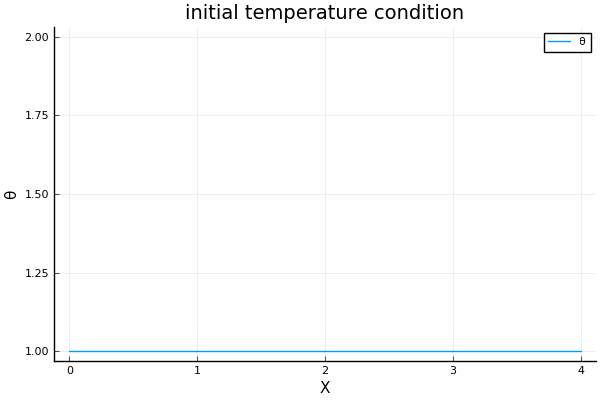

In [18]:
plot([sys0.wall.Xarray],[sys0.wall.θarray], title="initial temperature condition", labels = "θ", xlabel="X", ylabel="θ")

## Solve the constructed ODE for U

### propagation function

In [19]:
function dfdt(u,p,t)
    
        p = deepcopy(getcurrentsys(u,p))
    
        indexes = Int64[]
        θliquidtemp = Array[]

        for i = 1:length(u)
            if abs(u[i]+1e10) <= 10^(-1)
                push!(indexes,i)
            end
        end
    

    dynamicsdu = dynamicsmodel(u[1:indexes[1]-1],p)
    
    
    
    duwalltemp = wallmodel(u[indexes[1]+1:indexes[2]-1],p)
    walldu = duwallθtovec(duwalltemp)
    
    
    
    for i = 1:length(indexes)-2
    push!(θliquidtemp, u[indexes[i+1]+1:indexes[i+2]-1])
    end
    push!(θliquidtemp, u[indexes[end]+1:end])
    duliquidtemp = zero.(deepcopy(θliquidtemp))
    duliquidtemp = liquidmodel(θliquidtemp,p)
    liquiddu = duliquidθtovec(duliquidtemp)
    
    du = [dynamicsdu;walldu;liquiddu]

    return(du)

end

dfdt (generic function with 1 method)

### condition

In [20]:
(mod(0.050001,0.05) < 1e-7)

false

In [134]:
function condition(u,t,integrator)
    return (abs(mod(t,0.1)-0.1) < 1e-7) || mod(t,0.1) < 1e-7
end

condition (generic function with 1 method)

### affect! (with boundary conditions)

In [148]:
p

PHPSystem(Tube(0.03333333333333333, 4.0, 2.0, 1.5707963267948966, false), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 2.0)], [200.0]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(2.0, 4.0)], 3000.0), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(0.5, 2.5)], Tuple{Float64,Float64}[(0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5]], Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]), Vapor(1.4, [1.0, 1.0], [0.05, 0.05]), Wall(1.0, 0.05, [1.3145014719881525, 3.633825858889219], [0.0, 0.008016032064128256, 0.01603206412825

In [149]:
function affect!(integrator)
#     println("hahhaha")
    Δθthreshold = 0.01
    
    p = deepcopy(getcurrentsys(integrator.u,integrator.p))
    
    for i = 1:length(p.wall.Xstations)
        
        if ifamong(p.wall.Xstations[i], p.liquid.Xp)
            Δθ = getsuperheat(p.wall.Xstations[i],p)
            if Δθ > Δθthreshold
                p = nucleateboiling(p,(p.wall.Xstations[i]-0.01,p.wall.Xstations[i]+0.01),1.0)
            end
        end
        
                

        
    end
    
    Lvaporplug = XptoLvaporplug(p.liquid.Xp,p.tube.L,p.tube.closedornot)
    M = p.vapor.P.^(1/p.vapor.γ).* Lvaporplug
    
    unew=[XMδtovec(p.liquid.Xp,p.liquid.dXdt,M,p.vapor.δ); wallθtovec(p.wall.θarray); liquidθtovec(p.liquid.θarrays)];
        
#     set_u!(integrator,  unew)
    resize!(integrator.u,length(unew))
    integrator.u = deepcopy(unew)
    

end

affect! (generic function with 1 method)

In [162]:
cb =  DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, Bool[1, 1])

In [163]:
tstep=4e-5

p = sys0
tspan = (0.0, 0.4);
prob = ODEProblem(dfdt, u, tspan, p)

integrator = init(prob, RK4(), adaptive=false, dt=tstep);


# sol = solve(prob, RK4(), adaptive=false, dt=tstep);
sol = solve(prob, RK4(), adaptive=false,dt=tstep,callback=cb);

In [164]:
sysfinal = getcurrentsys.(sol.u,[sys0])

10007-element Array{PHPSystem,1}:
 PHPSystem(Tube(0.03333333333333333, 4.0, 2.0, 1.5707963267948966, false), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 2.0)], [200.0]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(2.0, 4.0)], 3000.0), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(0.5, 2.5)], Tuple{Float64,Float64}[(0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702811, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.451807228915663, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.483935742971888, 2.4919678714859437, 2.5]], Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]), Vapor(1.4, [1.0, 1.0], [0.05, 0.05]), Wall(1.0, 0.05, [1.3145014719881525, 3.633825858889219], [0.0, 0.008

In [165]:
result1=soltoMatrxResult(sol,sys0);

In [173]:
string("θliquid ",1)

"θliquid 1"

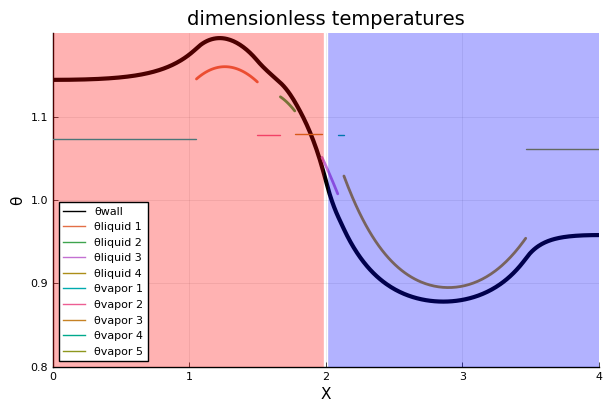

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\OneDThermalFlow\src\tmp.gif
└ @ Plots C:\Users\liyux\.juliapro\JuliaPro_v1.3.1-2\packages\Plots\ninUP\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\OneDThermalFlow\\src\\tmp.gif")
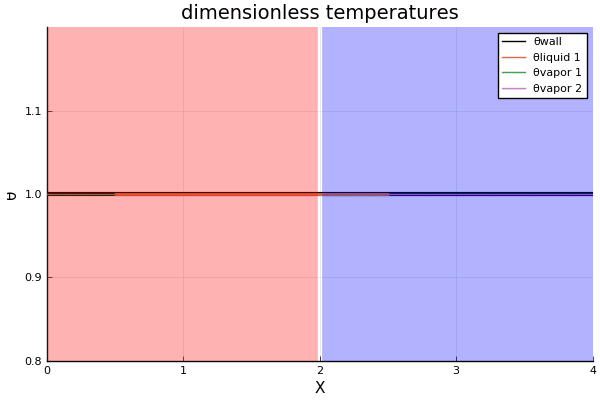

In [200]:
@gif for i=1:size(sol,2)
    
    Xpvapor = getXpvapor(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
    θvapor  = (sysfinal[i].vapor.P).^((γ-1)/γ)
    Xp = sysfinal[i].liquid.Xp
    
    p = plot([sysfinal[i].wall.Xarray],[sysfinal[i].wall.θarray], linewidth=3, color = [:black], labels = "θwall", xlabel="X", ylabel="θ", title=("dimensionless temperatures"),xlim=(0,4), ylim=(0.8,1.2))
    
    
    j=1
    while j <= length(Xp)
        plot!(p, [sysfinal[i].liquid.Xarrays[j]],[sysfinal[i].liquid.θarrays[j]], linewidth=2, labels = string("θliquid ",j))

        j += 1
    end
#     plot!(p,[Xpvapor[1][1],Xpvapor[1][end]],[θvapor[1]])
#     plot!(p,[Xpvapor[2][1],Xpvapor[2][end]],[θvapor[2]])  
    j=1
    while j <= length(θvapor)
    
        plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
        
        j += 1
    end

    vline!( p, [collect(0:4:4)], color=[:red,:blue], width=390, alpha=[0.3,0.3],labels = "")
    
    end every 50

In [201]:
Xstations

2-element Array{Float64,1}:
 1.3145014719881525
 3.633825858889219 